## ARCH model

The ARCH model is widely used to model financial return time series.
In this post, we always denote a time series by $(Y_t)$.
ARCH model is a specification of the conditional variance of $Y_t$ given its history $\mathcal F_{t-1}$
by the following equation: 
$$\mathrm{Var}[Y_t| \mathcal F_{t-1}] = \omega + \alpha Y_{t-1}^2.$$

In code, it is straightforward to define the ARCH model with the `arch` library. 

## `arch` library

In [1]:
import numpy as np
from arch import arch_model

In [2]:
rng = np.random.default_rng(41)
y = rng.normal(0,np.arange(500)*0.2,size=(500,))
mod = arch_model(y, mean='zero', q=0)
res = mod.fit(disp="off")
fcst = res.forecast(horizon=50, method="bootstrap", simulations=3)

Above  we exposed the main classes of the library.      
- `arch_model` is a convenience model constructor function with which one can specify the the mean process, the volatility (aka conditional standard deviation), the noise distribution (adhere to `scipy.stats`).  
- `mod.fit()` returns a result container: one can inspect residuals, standardised residuals, volatilities of the fit model.    
- `res.forecast()` returns a forecast container: one can make forecast of future paths, future conditonal variance etc.   

In [3]:
type(mod), type(res), type(fcst)

(arch.univariate.mean.ZeroMean,
 arch.univariate.base.ARCHModelResult,
 arch.univariate.base.ARCHModelForecast)

In [4]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -2719.79
Distribution:                  Normal   AIC:                           5443.58
Method:            Maximum Likelihood   BIC:                           5452.01
                                        No. Observations:                  500
Date:                Wed, Sep 25 2024   Df Residuals:                      500
Time:                        20:56:18   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       2082.8286    396.923      5.247  1.542e-07 [1.305e+03,2.861e+03]
alpha[1]       0.4962      0.174      2.850  4.377e-03     [  0.155,  0.838]
============================================================================

Covariance estimator: robust
"""

:NdOverlay   [Variable]
   :Curve   [index]   (value)
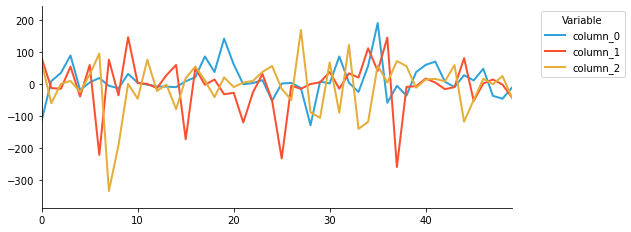

In [5]:
import polars as pl
import hvplot.polars
hvplot.extension('matplotlib')

pl.DataFrame(fcst.simulations.values.squeeze().T).hvplot() # 3 forecasted paths with horizon 50

<!-- ## Zooming in: the result summary

There are plenty of information in the summary. Most of them should be self-explanatory if one is familiar with basic terminology of statistical inference. Notice that the model we defind is `GARCH`, where "G" stands for "Generalised". A typical GARCH process is GARCH(1,1) defined through the specification: 
$$\mathrm{Var}[Y_t| \mathcal F_{t-1}] = \omega + \alpha Y_{t-1}^2 + \beta \mathrm{Var}[Y_{t-1}| \mathcal F_{t-2}].$$ -->


## Generalising a bit 

By default the noise distribution is standard normal. 
Another popular choice is t distribution where the degree of freedom $\nu$ is a model parameter.    
One can change the mean to be non-zero, i.e.  
$$
\begin{align*}
Y_t &= \mu + \sigma_t W_t \\  
\sigma_t^2 &= \omega+ \alpha (Y_{t-1}-\mu)^2
\end{align*}
$$
where $W_t$ is iid with t distribution. 

In code, it suffices to set `mean="constant"` and `dist="t"` in the constructor.  

In [6]:
arch_model(y=y+30, mean="constant", q=0, dist='t').fit(disp="off")

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -2679.58
Distribution:      Standardized Student's t   AIC:                           5367.17
Method:                  Maximum Likelihood   BIC:                           5384.03
                                              No. Observations:                  500
Date:                      Wed, Sep 25 2024   Df Residuals:                      499
Time:                              20:56:21   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            27

Why stop here? We can also allow the conditonal mean of $Y_t$ given history to vary with time as well, one simplest choice would be to 
assume AR dynamic for the conditional mean
$$
\begin{align*}
Y_t &= \mu + \phi (Y_{t-1} - \mu) + \sigma_t W_t \\  
\sigma_t^2 &= \omega+ \alpha (Y_{t-1}-\mu)^2
\end{align*}
$$
where as before $W_t$ is iid normal by default. 

In code, just set `mean="AR"` and `lags=[1]` where 1 is as in AR(1) for the conditional mean.  

In [7]:
arch_model(y=y+30, mean="AR", q=0, lags=[1]).fit(disp="off")

                           AR - ARCH Model Results                            
Dep. Variable:                      y   R-squared:                      -0.009
Mean Model:                        AR   Adj. R-squared:                 -0.011
Vol Model:                       ARCH   Log-Likelihood:               -2713.60
Distribution:                  Normal   AIC:                           5435.21
Method:            Maximum Likelihood   BIC:                           5452.06
                                        No. Observations:                  499
Date:                Wed, Sep 25 2024   Df Residuals:                      497
Time:                        20:56:21   Df Model:                            2
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         27.0729      2.670     10.139  3.727e-24 [ 21.839, 32.30

as before, we can inspect the result container and forecast container as follows

In [8]:
res = arch_model(y+30, mean="AR", q=0, lags=[1]).fit(disp="off")
fcst = res.forecast(horizon=5)

notice the difference of `resid` and `std_resid`, as well as the diff between `variance` and `residual_variance`

In [9]:
res.resid[1:].std(), res.std_resid[1:].std()

(58.660982953510256, 0.9984947367724978)

In [10]:
fcst.variance

,h.1,h.2,h.3,h.4,h.5
499,23351.435417,15524.642392,10963.391412,8315.005928,6777.289481


In [11]:
fcst.residual_variance

,h.1,h.2,h.3,h.4,h.5
499,23351.435417,15506.268989,10951.176295,8306.3797,6770.747058


In [4]:
from arch.univariate.mean import *

In [10]:
ConstantMean([1,2,3]).distribution

Normal distribution, id: 0x7f3275f2a210

## the recursion

consider zero mean with GARCH error: 
$$
\begin{align*}
Y_t &= \epsilon_t =  \sigma_t W_t \\
\sigma_{t}^2 &= \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 
\end{align*}
$$

fix $(\omega,\alpha,\beta)= (1, 0.3,0.6)$ and $\sigma_0=1$


<!-- we have $(\sigma_t)^2 - (\sigma_t')^2 = \alpha \sigma_{t-1} - \alpha \sigma_{t-1}$ -->

In [23]:
import numpy as np

n=100
om, al, be = 1, 0.3, 0.6
y = np.random.standard_normal(n) * np.arange(n) * 0.1

In [24]:
def get_vs(y, om,al,be, sig0=1.0):
    vs = np.full(y.size, sig0**2)
    for i in range(1,y.size):
        vs[i] = om + al * y[i]**2 + be * vs[i-1]
    return vs

In [25]:
vs1 = get_vs(y, om, al, be, sig0 = 1.0)
vs2 = get_vs(y, om, al, be, sig0 = 10.0)

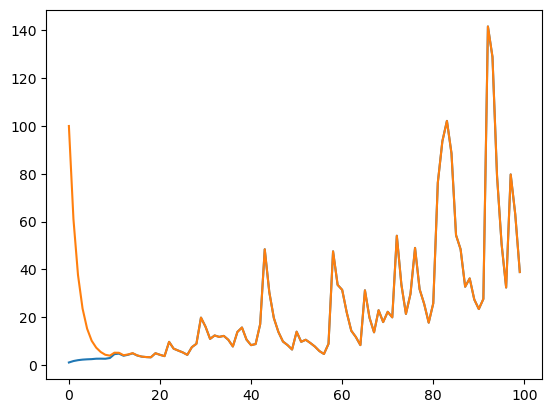

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vs1)
ax.plot(vs2)

In [27]:
np.isclose(vs1,vs2).argmax()

28

In [31]:
vs = get_vs(y,om,al,be)
vols = np.sqrt(vs)

In [34]:
horizon = 20
wns = np.random.standard_normal(horizon)

fcst_vs = np.empty(horizon)

last_v = vs[-1]
last_y = y[-1]

fcst_vs[0] = om + al* last_y + be* last_v
for i in range(1,horizon):
    fcst_vs[i] = om + (al+be) * fcst_vs[i-1]

In [35]:
fcst_vs

array([24.21795754, 22.79616179, 21.51654561, 20.36489105, 19.32840194,
       18.39556175, 17.55600557, 16.80040502, 16.12036451, 15.50832806,
       14.95749526, 14.46174573, 14.01557116, 13.61401404, 13.25261264,
       12.92735137, 12.63461624, 12.37115461, 12.13403915, 11.92063524])

In [36]:
def make_fcst_vs(om,al,be,last_v, last_y, horizon):
    fcst_vs = np.empty(horizon)
    fcst_vs[0] = om + al* last_y + be* last_v
    for i in range(1,horizon):
        fcst_vs[i] = om + (al+be) * fcst_vs[i-1]
    return fcst_vs

In [38]:
fcst_vs = make_fcst_vs(om,al,be,last_v,last_y, horizon)

In [39]:
fcst_vols = np.sqrt(fcst_vs)
fcst_y = fcst_vols * wns

In [41]:
fcst_y

array([-4.62714076, -1.76180401, -4.52910786, -2.68273839, -0.71521176,
        1.67327231,  1.23374823, -1.04082786,  5.86335136,  0.26458919,
       -3.57945346, -0.35142206, -2.41100437,  0.2429895 , -2.24143308,
        9.27766099,  5.18760589,  3.43163082, -0.19122127,  7.09264156])

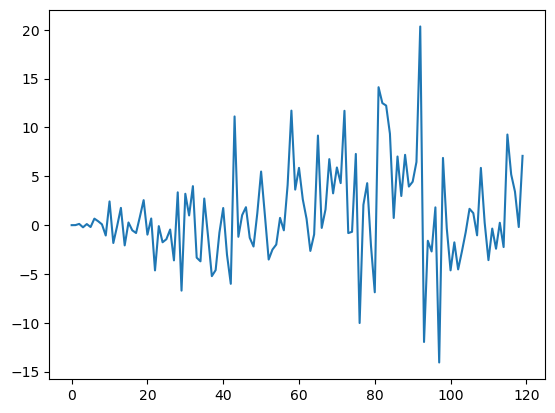

In [45]:
plt.plot(np.hstack([y,fcst_y]))

In [46]:
wns_bs = y/ vols

In [48]:
fcst_y_bs = fcst_vols * np.random.choice(wns_bs, size=(fcst_vols.size))

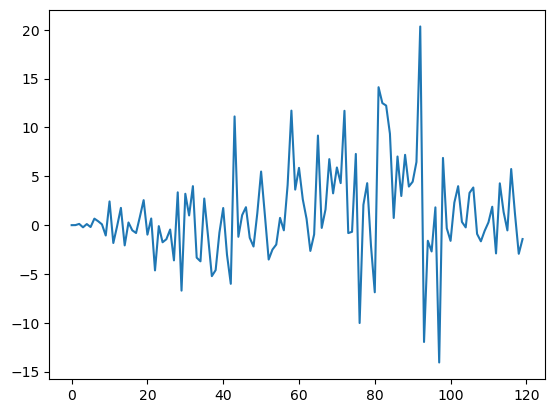

In [49]:
plt.plot(np.hstack([y,fcst_y_bs]))